### Описание данных  

Файл содержит [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) для некоторого актива. Стакан состоит из ценовых уровней и объема заявок на каждом уровне. Глубина стакана - 5.  

Описание колонок:  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку
midprice - цена актива  
signal - сигнал, полученный от модели, которая оценивает изменение цены 

#### Цена актива
На каждый тик определим цену актива. Возьмём среднее между наименьшим ask_rate (askbest) и наибольшим bid_rate (bidbest) в момент времени t:  
$$ midprice(t) = \frac{(askbest(t) + bidbest(t))}{2} $$  

С помощью сигнала от модели определим прогноз цены в будущем:  
$$midprice(t + 1) = midprice(t) + signal(t)$$

### Считывание данных

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtest import *

In [185]:
backtest_df = pd.read_parquet('test_quant.parquet')

In [186]:
backtest_df.tail()



,ask_rate,ask_amount,bid_rate,bid_amount,midprice,target,signal
index,,,,,,,
2019-09-18 06:08:46.227,"[380.02, 380.03, 380.04, 380.05, 380.07]","[4.57266, 54.3976, 0.50151, 0.48145, 0.50151]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 7.23986, 0.031, 1.45021, 10.41323]",380.015,-0.010,-0.000562
2019-09-18 06:08:46.427,"[380.02, 380.03, 380.04, 380.05, 380.06]","[9.0, 58.97026, 0.50151, 0.48145, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 7.23986, 0.24296, 0.02895, 10.41323]",380.015,-0.010,-0.002318
2019-09-18 06:08:46.527,"[380.02, 380.03, 380.04, 380.05, 380.06]","[13.57266, 54.3976, 0.50151, 0.48145, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 0.66331, 0.24296, 0.02895, 10.41323]",380.015,-0.010,-0.001896
2019-09-18 06:08:46.627,"[380.02, 380.03, 380.04, 380.05, 380.06]","[13.57266, 54.3976, 0.50151, 0.72768, 0.13]","[380.01, 380.0, 379.99, 379.98, 379.96]","[30.0, 0.66331, 0.031, 0.02895, 2.41323]",380.015,-0.010,-0.002480
2019-09-18 06:08:46.827,"[380.01, 380.02, 380.03, 380.05, 380.06]","[66.5, 4.57266, 54.3976, 0.24623, 0.13]","[380.0, 379.99, 379.98, 379.96, 379.94]","[0.66331, 0.031, 0.02895, 2.41323, 5.73953]",380.005,-0.055,-0.005292


count    787690.000000
mean          0.000097
std           0.036378
min          -0.675000
25%          -0.005000
50%           0.000000
75%           0.005000
max           0.660000
Name: target, dtype: float64


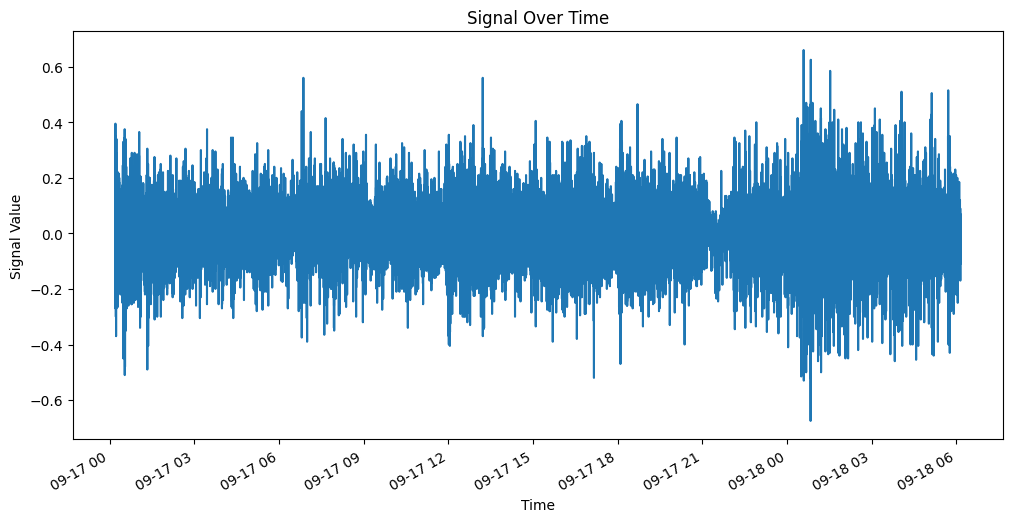

In [187]:
print(backtest_df['target'].describe())
plt.figure(figsize=(12, 6))
backtest_df['target'].plot()
plt.title("Signal Over Time")
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.show()

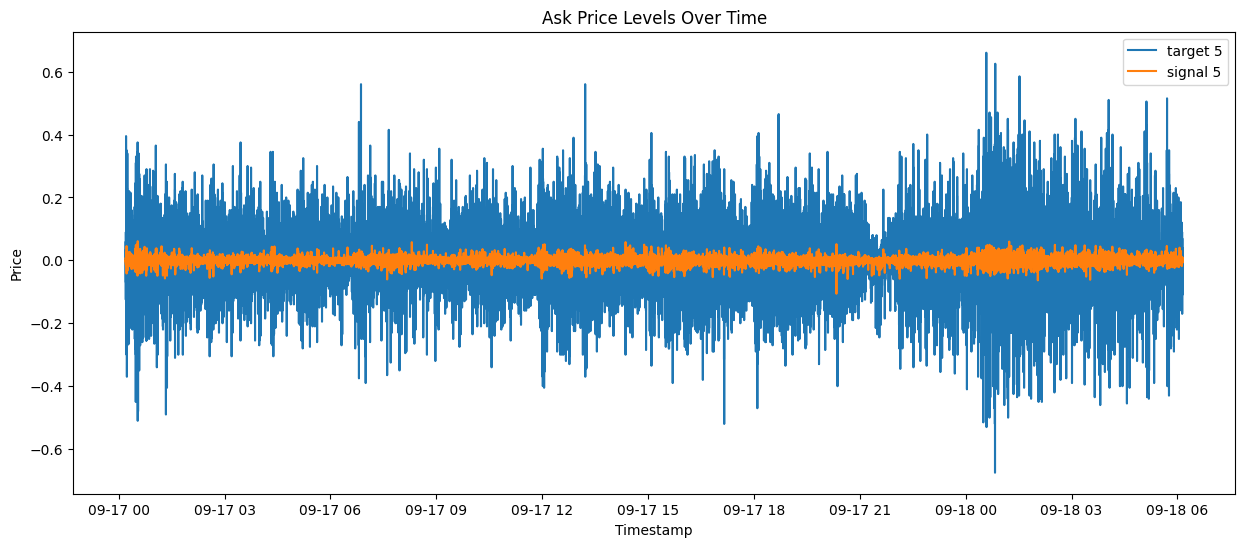

In [188]:

plt.figure(figsize=(15, 6))

# Plot each element in the nested 'ask_prices' over time

target = backtest_df['target']
plt.plot(backtest_df.index, target, label=f'target {i+1}')
signal = backtest_df['signal']
plt.plot(backtest_df.index, signal, label=f'signal {i+1}')

plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Ask Price Levels Over Time')
plt.legend()
plt.show()

In [189]:
backtest_df.shape

(787690, 7)

### Пример стратегии

#### Принцип работы стратегии  
I Ask price, Bid price and the price change, as well we would like to know if in the next step the price will go down or will go up, so if we know thsignal < 0 it means it will go down, that means that we should sell. For that purpose we see that if signal is < 0 but still not that much oscilating down, we might give some limits so if it is not too much not to do anything at all. Here we assign a variable min_treshold = 0.002. As well we know that if the price is expected to go down for next for a wile, we might as well sell almost all the position we have got, but at least all of our sell and buy amounts should be proportional to the signal, so if it gows down too fast, we should sell that fast and the otherwise. we should as well so smoothing as we dont wont to buy and sell evry litle move as it takes money. so in that case if we know that will be arbitrage oppportunity as the ask buy and mid points difference is much higher then the comission which is 0.0001 of the price.
 We might as well predict the signals trend, like if it will be pos or neg, and if it is neg we are opening more short positions if we can. 


Стратегия - это некоторый набор условий, по которому в каждый момент времени принимается решение, нужно ли сейчас покупать, продавать, либо ничего не делать.  
Результат работы стратегии - необходимый объем сделки (```order_size```). Если значение объема положительное - совершается покупка (buy). Если отрицательное - продажа (sell). Если 0 - ничего не происходит (hold).  

```order_size = 1``` — сделать покупку объемом 1  
```order_size = -1``` — сделать продажу объемом 1  

Совершение сделки на покупку изменяет текущую позицию (```current_position```) в положительную сторону, на продажу - в отрицательную.  
Текущая позиция отражает кумулятивную сумму купленных и проданных объемов.  
Пример изменения текущей позиции:  

```1. order_size = 0 -> current_position = 0```  
```2. order_size = 1 -> current_position = 1  # открытие позиции```  
```3. order_size = -1 -> current_position = 0  # закрытие позиции```  
  
Максимальная позиция (```max_position```) - наибольшее абсолютное значение текущей позиции. Если текущая позиция равна максимальной, нельзя совершать сделки в ту же сторону.  
При ```max_position = 1```:   

```1. order_size = 0 -> current_position = 0```  
```2. order_size = -1 -> current_position = -1```  
```3. order_size = -1 -> current_position = -1  # нельзя превысить max_position```   
```4. order_size = 1 -> current_position = 0```   

In [190]:
def basic_strategy(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    '''
    Описание стратегии
    --------------
    Совершает покупку, если сигнал положительный и текущая абсолютная позиция меньше максимальной.
    Совершает продажу, если сигнал отрицательный и текущая абсолютная позиция меньше максимальной.
    
    Параметры
    --------------
    strategy_state : list
        Массив, содержащий index (номер тика), current_position (текущую позицию)
        и signal (сигнал модели для данного тика).
    orderbook_state : list
        Массив, содержащий информацию о стакане для данного тика.
    trade_size : float
        Объем одной сделки.
    storage : dict
        Словарь для сохранения информации с прошлых тиков.
    max_position : int
        Максимальный объем открытой позиции в одну сторону. Должен быть равен 1.
    
    Результат
    --------------
    order_size : float
        Стратегия возвращает объем сделки, где знак обозначает сторону сделки: 
        положительный для покупки и отрицательный для продажи
    '''
    index, current_position, signal = strategy_state
    
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    
    # prev_signal = storage.get('prev_signal', 0)  # пример использования storage
    if signal > 0:  # покупка
        order_size = min(trade_size, max_position - current_position)  # определение объема сделки
    elif signal < 0:  # продажа
        order_size = -min(trade_size, max_position + current_position)  # определение объема сделки
    else:
        order_size = 0
    # storage['prev_signal'] = signal  # пример использования storage
    
    return order_size

In [191]:
from collections import deque

def smoothed_strategy(strategy_state, orderbook_state, trade_size, storage, max_position=1, window_size=10, cooldown_period=5):
    '''
    Описание стратегии
    --------------
    Усиленная стратегия с использованием скользящего окна для сглаживания сигнала.
    Сделки совершаются только при значительном отклонении от среднего уровня сигнала.
    
    Параметры
    --------------
    strategy_state : list
        Массив, содержащий index (номер тика), current_position (текущую позицию) и signal (сигнал модели для данного тика).
    orderbook_state : list
        Массив, содержащий информацию о стакане для данного тика.
    trade_size : float
        Объем одной сделки.
    storage : dict
        Словарь для хранения данных предыдущих тиков.
    max_position : int
        Максимальный объем открытой позиции в одну сторону. Должен быть равен 1.
    window_size : int
        Размер окна для расчета скользящего минимума и максимума сигнала.
    cooldown_period : int
        Минимальное количество тиков между сделками.
    
    Результат
    --------------
    order_size : float
        Стратегия возвращает объем сделки, где знак обозначает сторону сделки: 
        положительный для покупки и отрицательный для продажи
    '''
    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state

    # Инициализация очередей для хранения последних сигналов
    if 'signal_window' not in storage:
        storage['signal_window'] = deque(maxlen=window_size)
    if 'last_trade_tick' not in storage:
        storage['last_trade_tick'] = -cooldown_period

    # Обновление очереди сигналов и расчет скользящего минимума и максимума
    storage['signal_window'].append(signal)
    signal_min = min(storage['signal_window'])
    signal_max = max(storage['signal_window'])
    last_trade_tick = storage['last_trade_tick']

    # Ограничение частоты сделок
    if index - last_trade_tick < cooldown_period:
        order_size = 0

    # Условия для открытия/закрытия позиций на основе скользящего минимума и максимума
    elif signal > signal_max and current_position < max_position:  # Покупка
        order_size = min(trade_size, max_position - current_position)
        last_trade_tick = index
    elif signal < signal_min and current_position > -max_position:  # Продажа
        order_size = -min(trade_size, max_position + current_position)
        last_trade_tick = index

    # Условия для закрытия позиций, если сигнал возвращается к средним значениям
    elif signal < 0 and current_position > 0:  # Закрытие позиции покупки
        order_size = -min(current_position, trade_size)
        last_trade_tick = index
    elif signal > 0 and current_position < 0:  # Закрытие позиции продажи
        order_size = min(-current_position, trade_size)
        last_trade_tick = index
    else:
        order_size = 0

    # Обновление состояния хранилища
    storage['last_trade_tick'] = last_trade_tick

    return order_size


In [195]:
def strategy_trading(strategy_state, orderbook_state, trade_size, storage, max_position=1):
    treshold = 0.03
    min_treshold = 0.002
    comission = 0.0001

    index, current_position, signal = strategy_state
    ask_rate, ask_amount, bid_rate, bid_amount = orderbook_state
    ask_best = min(ask_rate)
    bid_best = max(bid_rate)
    spread = bid_best - ask_best
    mid_price = (ask_best + bid_best) / 2

    ask_liquidity = sum(ask_amount)
    bid_liquidity = sum(bid_amount)

    # Initialize previous signals storage
    if 'previous_signals' not in storage:
        storage['previous_signals'] = []
    storage['previous_signals'].append(signal)
    
    # Keep track of the last 200 signals +
    if len(storage['previous_signals']) > 50:
        storage['previous_signals'].pop(0)
    order_size = 0

    # Smoothed signal is the average of previous signals+
    smoothed_signal = sum(storage['previous_signals']) / len(storage['previous_signals'])

    # If smoothed signal is greater than commission threshold, evaluate conditions
    if smoothed_signal > comission:
        if spread > treshold and signal > 0:
            order_size = min(trade_size*signal, max_position - current_position)  # Buy signal
        elif abs(spread) > min_treshold  and signal > 0:
            order_size = min(trade_size * smoothed_signal, max_position - current_position)  # Buy signal with scaling based on smoothed signal
        elif abs(spread) > min_treshold and signal < 0:
            order_size = -min(trade_size * abs(smoothed_signal), max_position + current_position)  # Sell signal
        elif spread < treshold and signal < 0:
            order_size = -min(trade_size*abs(signal), max_position + current_position)  # Buy signal
    # No action if the smoothed signal does not meet commission threshold
    else:
        order_size = 0


    # Store the previous signal for next iteration
    storage['prev_signal'] = signal
    
    return order_size


In [193]:
strategy_params = {}
strategy_params['trade_size'] = 1  # максимальное значение = 1
strategy_params['storage'] = {}  

### Бэктест
Для проверки качества стратегии используются исторические данные, на которых с помощью бэктеста симулируется работа стратегии

{'pnl': 20.346068623407408, 'pnl_after_fee': 14.24414977038745, 'actions': 257459}


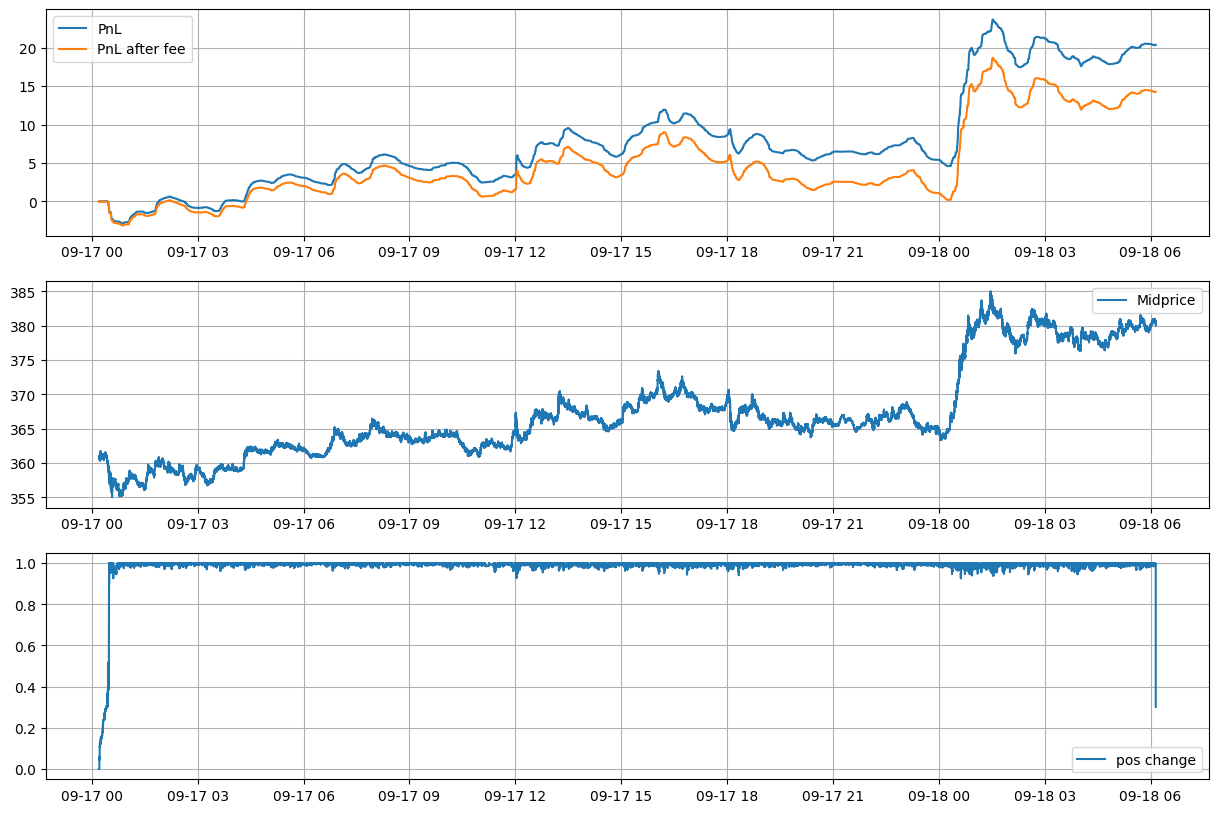

In [196]:
summary, result = backtest(backtest_df, strategy_trading, strategy_params, viz=True)

Бэктест возвращает результат работы стратегии.  
```summary``` содержит итоговую информацию:
- pnl : Profits and Losses (PnL, P&L) - сумма всех доходов и убытков по закрытым позициям. 
- **pnl_after_fee : Pnl после комиссии. За каждую сделку биржа берёт комиссию. В данном случае она составляет 0.0001 от цены актива в момент совершения сделки. Это ключевой показатель при анализе эффективности стратегии.**  
- actions : Количество сделок, совершенное стратегией  

Выводы по этой стратегии:  
Она слишком чувствительна к сигналу, поэтому совершает большое количество сделок, из которых почти все убыточны. 

```result``` - исходный датафрейм, к которому добавлены данные по стратегии в каждый момент времени. Может использоваться для детального анализа работы стратегии

### Задачa
Написать свою торговую стратегию, которая будет опираться на сигнал модели для принятия решения.  
#### Ограничения: 
- Максимальная позиция не должна превышать 1
- Нельзя самостоятельно вносить изменения в бэктест
- Стратегия должна содержать текстовое описание  

#### Критерии оценки стратегии:
- Pnl после комиссии 
- Количество сделок > 50